# Subject: Machine Learning, 1st March 2024 to 3rd May 2024.
## Topic: Group Project (Task B)
## Learning Outcomes:
- MO2: Select and apply machine learning algorithms to formulate 
solutions to different types of machine learning problems, taking 
into account criteria such data availability and characteristics, and 
problem-specific requirements for balancing speed, accuracy, and 
explainability.

- MO3: Implement and evaluate contemporary machine learning 
solutions to application problems using a range of contemporary 
frameworks.

- MO4: Demonstrate an awareness of the ethical and societal 
implications of machine learning solutions. 


**NOTE:** To pylint your code type "pip install nbqa pylint //
nbqa pylint my_notebook.ipynb".

In [365]:
import subprocess
import os


current_directory = os.path.dirname(os.path.abspath("main.ipynb"))
current_directory += "/"

def install(requirements):
    """
    Install all the relevent project dependencies.
    """

    try:
        if os.path.isdir('.venv'):
            activate_script = os.path.join('.venv', 'bin', 'activate')
            subprocess.check_call(['source', activate_script], shell=True)

        with open(requirements, 'r') as f:
            requirements = f.read().splitlines()
            subprocess.check_call(['pip', 'install'] + requirements)
        print("Installed dependencies.")

    except FileNotFoundError:
        print(f"File '{requirements}' not found.")
    except subprocess.CalledProcessError:
        pass

if __name__ == "__main__":
    install(current_directory + "project/requirements.txt")



Installed dependencies.


## Model Variables
Below are the variables we can use to fine-tune our models.

In [366]:
N_TIMESTEP = 10
TEST_SIZE = 0.15
UNITS = 128
ACTIVATION_FUNCTION = "relu" # Non-linear
RNN_ACTIVATION_FUNCTION = "sigmoid" # Linear
RNN_OPTIMISER = "adam"
LOSS_ERROR = "mse"

# Preprocessing our data

In [367]:
import pandas as pd
import datetime as dt
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

raw_data = pd.read_csv(current_directory + "project/raw_data/BTC-USD.csv")
df = raw_data[["Date", "Close"]]

def to_datetime(s: str):
    year, month, day = s.split("-")
    return dt.datetime(
        int(year),
        int(month),
        int(day)
    )

close = df["Close"]
dates = df["Date"].apply(to_datetime)
print(df)

            Date         Close
0     2020-03-08   8108.116211
1     2020-03-09   7923.644531
2     2020-03-10   7909.729492
3     2020-03-11   7911.430176
4     2020-03-12   4970.788086
...          ...           ...
1458  2024-03-05  63801.199219
1459  2024-03-06  66106.804688
1460  2024-03-07  66925.484375
1461  2024-03-08  68300.093750
1462  2024-03-09  68498.882812

[1463 rows x 2 columns]


### Partitioning and Normalisation
Get the training set, validation set and test set for the model to work.

In [368]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare X and y
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_price = 'ScaledClosePrice'
df[scaled_close_price] = scaler.fit_transform(df[["Close"]])


# N_TIMESTEP = 10 #
n_samples = len(dates)
print(n_samples)

X = []
y = []
for i in range(len(df) - N_TIMESTEP):  # Adjusted loop iteration range
    # Historical close prices
    X.append(df[scaled_close_price].values[i:i+N_TIMESTEP])

    # Future close price from dataset
    y.append(df[scaled_close_price].values[i+N_TIMESTEP])

X = np.array(X)
y = np.array(y)

print(X, "length:", len(X))
print(y)

1463
[[4.93848924e-02 4.64811114e-02 4.62620738e-02 ... 6.63528250e-03
  6.87757042e-04 4.01147413e-03]
 [4.64811114e-02 4.62620738e-02 4.62888444e-02 ... 6.87757042e-04
  4.01147413e-03 4.21310275e-03]
 [4.62620738e-02 4.62888444e-02 0.00000000e+00 ... 4.01147413e-03
  4.21310275e-03 1.92104736e-02]
 ...
 [7.79995284e-01 8.20339147e-01 9.05646568e-01 ... 9.97348122e-01
  9.26053447e-01 9.62346138e-01]
 [8.20339147e-01 9.05646568e-01 8.85082340e-01 ... 9.26053447e-01
  9.62346138e-01 9.75233030e-01]
 [9.05646568e-01 8.85082340e-01 9.04636680e-01 ... 9.62346138e-01
  9.75233030e-01 9.96870848e-01]] length: 1453
[0.0042131  0.01921047 0.01932988 ... 0.97523303 0.99687085 1.        ]


In [369]:
# Split the data into Samples, steps, then features
X = np.reshape(X, (X.shape[0], N_TIMESTEP, 1))
print(len(X))

# Split the data into train, test and validation
# First, split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, shuffle=False
)

# Calc validation remainder: (0.15 * (1 - 0.15)) / (1 - 0.15)
validation_size = (TEST_SIZE * (1.0 - TEST_SIZE)) / (1.0 - TEST_SIZE)

# Split the remaining data into validation and new train sets
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=validation_size, shuffle=False
)

print("Training set:", len(X_train)/len(close), "%")
print("Validation set:", len(X_validation)/len(close), "%")
print("Test set:", len(X_test)/len(close), "%")


1453
Training set: 0.7170198222829802 %
Validation set: 0.127136021872864 %
Test set: 0.14900888585099112 %


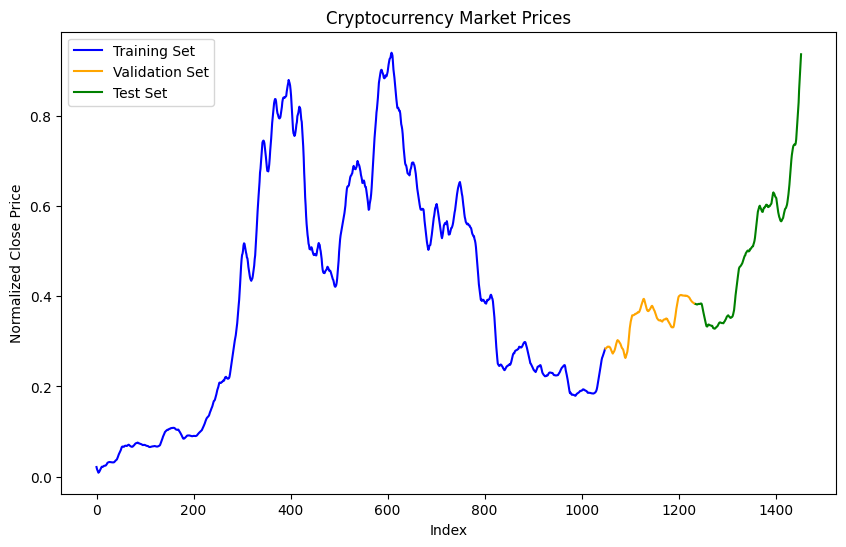

In [370]:
import matplotlib.pyplot as plt

# Calculate the indices for train, validation, and test sets
train_start, train_end = 0, len(X_train) - 1
validation_start, validation_end = len(X_train), len(X_train) + len(X_validation) - 1
test_start, test_end = len(X_train) + len(X_validation), len(X_train) + len(X_validation) + len(X_test) - 1

plt.figure(figsize=(10, 6))

# Plot train set
plt.plot(range(train_start, train_end + 1), np.mean(X_train[:, :, 0], axis=1), color='blue', label="Training Set")

# Plot validation set
plt.plot(range(validation_start, validation_end + 1), np.mean(X_validation[:, :, 0], axis=1), color='orange', label="Validation Set")

# Plot test set
plt.plot(range(test_start, test_end + 1), np.mean(X_test[:, :, 0], axis=1), color='green', label="Test Set")

plt.xlabel('Index')
plt.ylabel('Normalized Close Price')
plt.title("Cryptocurrency Market Prices")
plt.legend()
plt.show()


In [371]:
# # Visualise the data:
target_variable = 'Next Close'
X_reshaped = np.reshape(X, (X.shape[0], -1))
X_df = pd.DataFrame(X_reshaped, columns=[f"Close_{i}" for i in range(X.shape[1])])
y_df = pd.DataFrame(y, columns=[target_variable])
data_df = pd.concat([X_df, y_df], axis=1)

# Display the DataFrame
print(len(data_df[target_variable]))

1453


## Creating the Models

In [372]:
import tensorflow as tf

try:
    from keras.api.models import Sequential
    from keras.api.layers import LSTM, Dense
except ImportError:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM

def create_model(
    units: int,
    activation: str = "relu",
    recurrent_activation: str = "sigmoid",
    optimizer: str = "adam"
) -> Sequential:

    model = Sequential()
    model.add(LSTM(
        units,
        activation=activation,
        recurrent_activation=recurrent_activation,
        # return_sequences=True,
        return_sequences=False,
        input_shape=(N_TIMESTEP, 1)
    ))

    # Output Layer. Updates dimensionality.
    model.add(Dense(
        1
    ))

    model.compile(optimizer=optimizer, loss=LOSS_ERROR)
    return model

lstm_model = create_model(
    units=UNITS,
    activation=ACTIVATION_FUNCTION,
    recurrent_activation=RNN_ACTIVATION_FUNCTION,
    optimizer=RNN_OPTIMISER
)

print(X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_validation.shape, y_validation.shape)

(1453, 10, 1) (1453,) (1049, 10, 1) (1049,) (218, 10, 1) (218,) (186, 10, 1) (186,)


c:\Program Development\UWE Bristol\Year 2\Machine Learning\github\v1\uni-machine-learning\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [377]:
from tensorflow.keras.callbacks import EarlyStopping

# We use this object to monitor the loss of the model.
# After 'patient' consecutive attempts if no improvement we stop running the model.
# We use val_loss since we are fine-tuning with validation data.
loss_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Fit the model.
# Since we dont have explicit labels for validation monitor performance
# during training instead.
model_data = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[loss_callback],
    verbose=False
)

# Pass in true values to evaluate loss
model_loss = lstm_model.evaluate(X_test, y_test)
predictions = lstm_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4681e-04 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


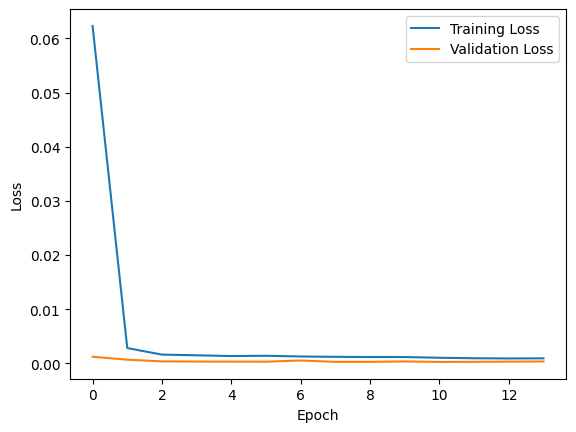

In [374]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.plot(model_data.history['loss'], label='Training Loss')
plt.plot(model_data.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Grid Search the Models

In [375]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

# # Create a keras wrapper for sklearn grid search
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, func, **kwargs):
        self.func = func
        self.kwargs = kwargs

    def fit(self, X, y, **kwargs):
        self.model = self.func(**kwargs)
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

# regressor_model = KerasRegressor(lstm_model, verbose=0)

# grid_search_params = {
#     "units": [32, 64, 128]
# }

# def create_grid_search():
#     model = GridSearchCV()